## miary dystrybucyjne i typu wordnet

### importy


In [6]:
import numpy as np
import scipy as sc
import scipy.spatial
import os
import pandas as pd
from collections import OrderedDict
from tqdm.notebook import tqdm
import seaborn as sns

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')
#https://keras.io/examples/nlp/pretrained_word_embeddings/
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !cp "/content/gdrive/My Drive/datasets/glove.6B.zip" .
# !unzip -q glove.6B.zip

### pobranie danych


In [8]:
#download the embeddings if not already there:
if not os.path.exists('./nkjp+wiki-lemmas-all-100-cbow-hs.txt'):
    if not os.path.exists('./nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz'):
        !wget http://dsmodels.nlp.ipipan.waw.pl/dsmodels/nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz
    !gzip -d nkjp+wiki-lemmas-all-100-cbow-hs.txt.gz
# if not os.path.exists('./nkjp+wiki-forms-all-100-cbow-hs.txt'):
#     if not os.path.exists('./nkjp+wiki-forms-all-100-cbow-hs.txt.gz'):
#         !wget http://dsmodels.nlp.ipipan.waw.pl/dsmodels/nkjp+wiki-forms-all-100-cbow-hs.txt.gz
#     !gzip -d nkjp+wiki-forms-all-100-cbow-hs.txt.gz
# if not os.path.exists('./kgr10.plain.skipgram.dim100.neg10.vec'):
#     !wget "https://nextcloud.clarin-pl.eu/index.php/s/luubhnS0AvjmtQc/download?path=%2F&files=kgr10.plain.skipgram.dim100.neg10.vec" -O kgr10.plain.skipgram.dim100.neg10.vec
if not os.path.exists('./MSimLex999_Polish.txt'):
    if not os.path.exists('./MSimLex999_Polish.zip'):
        !wget "http://zil.ipipan.waw.pl/CoDeS?action=AttachFile&do=get&target=MSimLex999_Polish.zip" -O MSimLex999_Polish.zip
    !unzip MSimLex999_Polish.zip

### komparatory ocen podobieństwa

In [9]:
def levenshteinDistance(s1, s2): # unused
    #https://stackoverflow.com/a/32558749
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

def HeuricticScoringMetric(s1, s2):
    #s1, s2 must be sorted pandas.Series objects
    s2_val = s2.iloc[0]
    score = 0
    for s1_idx, s1_val in s1.items():
        s2_next_val = s2.loc[s1_idx]
        if s2_next_val >= s2_val:
            score += 1
        s2_val = s2_next_val
    return score

### klasa licząca odległości/podobieństwa

In [38]:
class DistanceCalculator():
    def __init__(self,
                #  filepaths_to_embeddings={'waw_embed':'nkjp+wiki-lemmas-all-100-cbow-hs.txt',
                #                           'wro_embed':'kgr10.plain.skipgram.dim100.neg10.vec'},
                 filepaths_to_embeddings={'embed':'nkjp+wiki-lemmas-all-100-cbow-hs.txt'},
                 wordnet_parameter_1=None,
                 wordnet_parameter_2=None,
                 ):
        self.embeddings_dicts = {
            key:self.embedings_from_file(path)
            for key, path in filepaths_to_embeddings.items()
        }

    def simlex_eval(self, simlex_path='MSimLex999_Polish.txt'):
        simlex_pl = pd.read_csv(simlex_path, sep='\t', index_col='idx',
                                names=['idx','word1','word2','similarity','relatedness'])
        dostances = []
        indexes = []
        for i, row in simlex_pl.iterrows():
            try:
                d = dc.calculate_distances(row.word1, row.word2)
            except KeyError:
                print(f'info: one of keys ({row.word1}, {row.word2}) not found in dictionary')
                continue
            dostances.append(d)
            indexes.append(i)
        dostances = pd.DataFrame(dostances)
        dostances.set_index(pd.Index(indexes, name='idx'))
        self.simlex_pl = simlex_pl.merge(dostances, left_index=True, right_index=True)
        return self.list_distances(self.simlex_pl.drop(columns=['word1','word2']))

    def list_distances(self, pd_metrics):
        #levenshteinDistance:
        M = len(pd_metrics.columns)
        score_matrix = [[None]*M for i in range(M)]
        for i, c1 in enumerate(pd_metrics.columns):
            for j, c2 in enumerate(pd_metrics.columns):
                score_matrix[i][j] = HeuricticScoringMetric(pd_metrics[c1].sort_values(), 
                                                            pd_metrics[c2].sort_values())
        return pd.DataFrame(score_matrix, index=pd_metrics.columns, columns=pd_metrics.columns)

    def embedings_from_file(self, path):
        embeddings = {}
        print(f'reading file {path} ...')
        with open(path) as f:
            for line in tqdm(f):
                word, coefs = line.split(maxsplit=1)
                coefs = np.fromstring(coefs, "f", sep=" ")
                embeddings[word] = coefs
        return embeddings

    def cosine_similarity(self, wordA, wordB, embeddings):
        return sc.spatial.distance.cosine(embeddings[wordA], embeddings[wordB])

    def l2_similarity(self, wordA, wordB, embeddings):
        return np.linalg.norm(embeddings[wordA] - embeddings[wordB])

    def distribution_distances(self, wordA, wordB):
        result = {}
        for dictionary_name, embeddings in self.embeddings_dicts.items():
            result.update({
                f'cosine_distance_{dictionary_name}': self.cosine_similarity(wordA, wordB, embeddings),
                f'euclidean_distance_{dictionary_name}': self.l2_similarity(wordA, wordB, embeddings),
            })
        return result

    def wordnet_distances(self, wordA, wordB):
        result = {}
        pass #TODO
        return result

    def calculate_distances(self, wordA, wordB):
        result = {}
        result.update(self.distribution_distances(wordA, wordB))
        result.update(self.wordnet_distances(wordA, wordB))
        return result

    def get_K_closest_to_wordA_from_list(self, wordA, list_of_words, K=5):
        results = {}
        for wordB in list_of_words:
            try:
                distances = self.calculate_distances(wordA, wordB)
            except KeyError:
                print(f'info: one of keys ({wordA}, {wordB}) not found in dictionary')
                continue
            results[wordB] = distances
        pd_results = pd.DataFrame(results).T
        result = {}
        for metric, all_distances in pd_results.items():
            result[metric] = all_distances.sort_values()[:K].to_dict(into=OrderedDict)
        return result

## obserwacje

In [39]:
dc = DistanceCalculator()

reading file nkjp+wiki-lemmas-all-100-cbow-hs.txt ...


In [29]:
dc.calculate_distances('kot','pies')

{'cosine_distance_embed': 0.15627360343933105,
 'euclidean_distance_embed': 8.467666}

In [30]:
dc.calculate_distances('kot','lodówka')

{'cosine_distance_embed': 0.6711545884609222,
 'euclidean_distance_embed': 17.376816}

In [31]:
dc.calculate_distances('pływać','różowy')

{'cosine_distance_embed': 0.8321841508150101,
 'euclidean_distance_embed': 19.901152}

info: one of keys (przestraszony, zalękniony) not found in dictionary
info: one of keys (obładowany, ciężki) not found in dictionary
info: one of keys (głupi , rzadki) not found in dictionary
info: one of keys (pieniądze, pensja) not found in dictionary
info: one of keys (łódź, kotwica) not found in dictionary
info: one of keys (łódź, pokład) not found in dictionary
info: one of keys (ubrania, szuflada) not found in dictionary
info: one of keys (pieniądze, kapitał) not found in dictionary
info: one of keys (łódź, samochód) not found in dictionary
info: one of keys (dąb , klon) not found in dictionary
info: one of keys (nasiona, musztarda) not found in dictionary
info: one of keys (silnik, łódź) not found in dictionary
info: one of keys (mężczyźni, bractwo) not found in dictionary
info: one of keys (mieszkanie, meble) not found in dictionary
info: one of keys (populacja, ludzie) not found in dictionary
info: one of keys (ludzie, cent) not found in dictionary
info: one of keys (ludzie, p

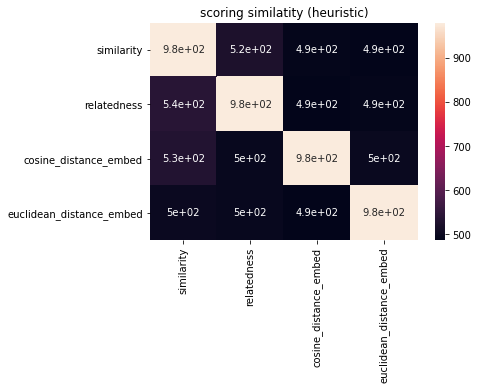

In [32]:
most_simillar_metrics = dc.simlex_eval('MSimLex999_Polish.txt')
sns.heatmap(most_simillar_metrics, annot=True).set(title='scoring similatity (heuristic)');

In [33]:
setA = !awk '{print $2}' MSimLex999_Polish.txt
setB = !awk '{print $3}' MSimLex999_Polish.txt
tiny_corpus = set(setA) | set(setB)

In [40]:
dc.get_K_closest_to_wordA_from_list('bystry', tiny_corpus, K=10)

info: one of keys (bystry, przestraszony) not found in dictionary
info: one of keys (bystry, meble) not found in dictionary
info: one of keys (bystry, obładowany) not found in dictionary
info: one of keys (bystry, mężczyźni) not found in dictionary
info: one of keys (bystry, pieniądze) not found in dictionary
info: one of keys (bystry, nasiona) not found in dictionary
info: one of keys (bystry, ubrania) not found in dictionary
info: one of keys (bystry, ludzie) not found in dictionary
info: one of keys (bystry, łódź) not found in dictionary


{'cosine_distance_embed': OrderedDict([('bystry', 0.0),
              ('chłopiec', 0.6090092957019806),
              ('usposobienie', 0.6341421008110046),
              ('gniewny', 0.644877701997757),
              ('zalękniony', 0.6508411467075348),
              ('pogoda', 0.6550817787647247),
              ('chłopak', 0.6673302054405212),
              ('dziewczyna', 0.6772406697273254),
              ('szałas', 0.7002425193786621),
              ('opowieść', 0.7058223783969879)]),
 'euclidean_distance_embed': OrderedDict([('bystry', 0.0),
              ('spowiedż', 14.164617538452148),
              ('zalękniony', 14.839924812316895),
              ('koncept', 15.128437995910645),
              ('ogar', 15.193888664245605),
              ('zgraja', 15.26916217803955),
              ('głupol', 15.381369590759277),
              ('gin', 15.476540565490723),
              ('wielkoduszny', 15.702993392944336),
              ('prędki', 15.719139099121094)])}